In [53]:
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets, sklearn.model_selection
from progressbar import progressbar
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
pd.options.display.float_format = '{:.6f}'.format

In [55]:
X, y = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y, X = y.astype(np.int64), X.reshape(-1, 784).astype(np.float32)
X = X / 255
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=47)

# Just a simple compression

In [56]:
EPOCHS=1000
BATCH_SIZE=128

encoder = torch.nn.Sequential(
    torch.nn.Linear(784, 100),
    torch.nn.Tanh(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(100, 2),
    torch.nn.Tanh(),
)

decoder = torch.nn.Sequential(
    torch.nn.Linear(2, 500),
    torch.nn.Tanh(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(500, 784),
    torch.nn.Sigmoid(),
)

model = torch.nn.Sequential(
    encoder,
    decoder
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

lossFn = torch.nn.BCELoss()


In [57]:
losses = []
for epoch in progressbar(range(EPOCHS)):
    loss_agg = 0
    order = np.random.permutation(train_data.shape[0])
    train_x = train_data[order]
    train_y = train_target[order]
    for i in range(0, train_x.shape[0] // BATCH_SIZE):
        batch_x = torch.from_numpy(train_x[i*BATCH_SIZE:(i+1)*BATCH_SIZE])

        optimizer.zero_grad()
        output = model(batch_x)
        loss = lossFn(output, batch_x)
        loss.backward()
        optimizer.step()
        loss_agg += loss.item()
    losses.append(loss_agg)

100% (1000 of 1000) |####################| Elapsed Time: 0:34:29 Time:  0:34:291848


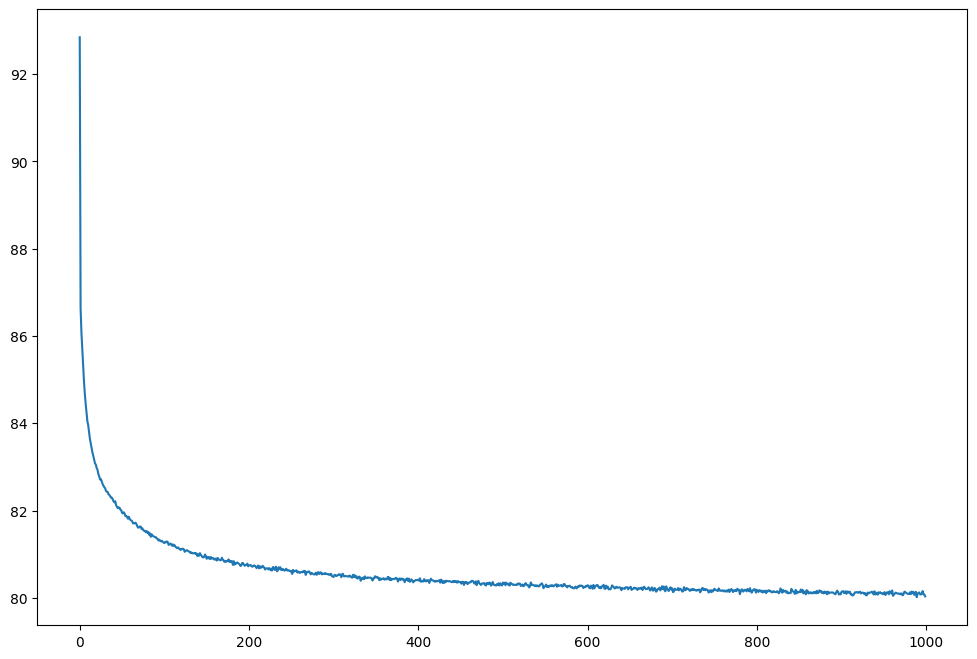

In [58]:
plt.figure(figsize=(12, 8))
plt.plot(losses)
plt.show()

In [59]:
torch.save(model.state_dict(), 'simple_autoencoder.pth')

In [60]:
model.load_state_dict(torch.load('simple_autoencoder.pth'))

<All keys matched successfully>

In [61]:
with torch.no_grad():
    sample_data = torch.tensor([[[i / 5 - 1, j / 5 - 1] for j in range(10)] for i in range(10)]).reshape((-1, 2))
    sample_out = decoder(sample_data).numpy().reshape(10, 10, 28, 28)

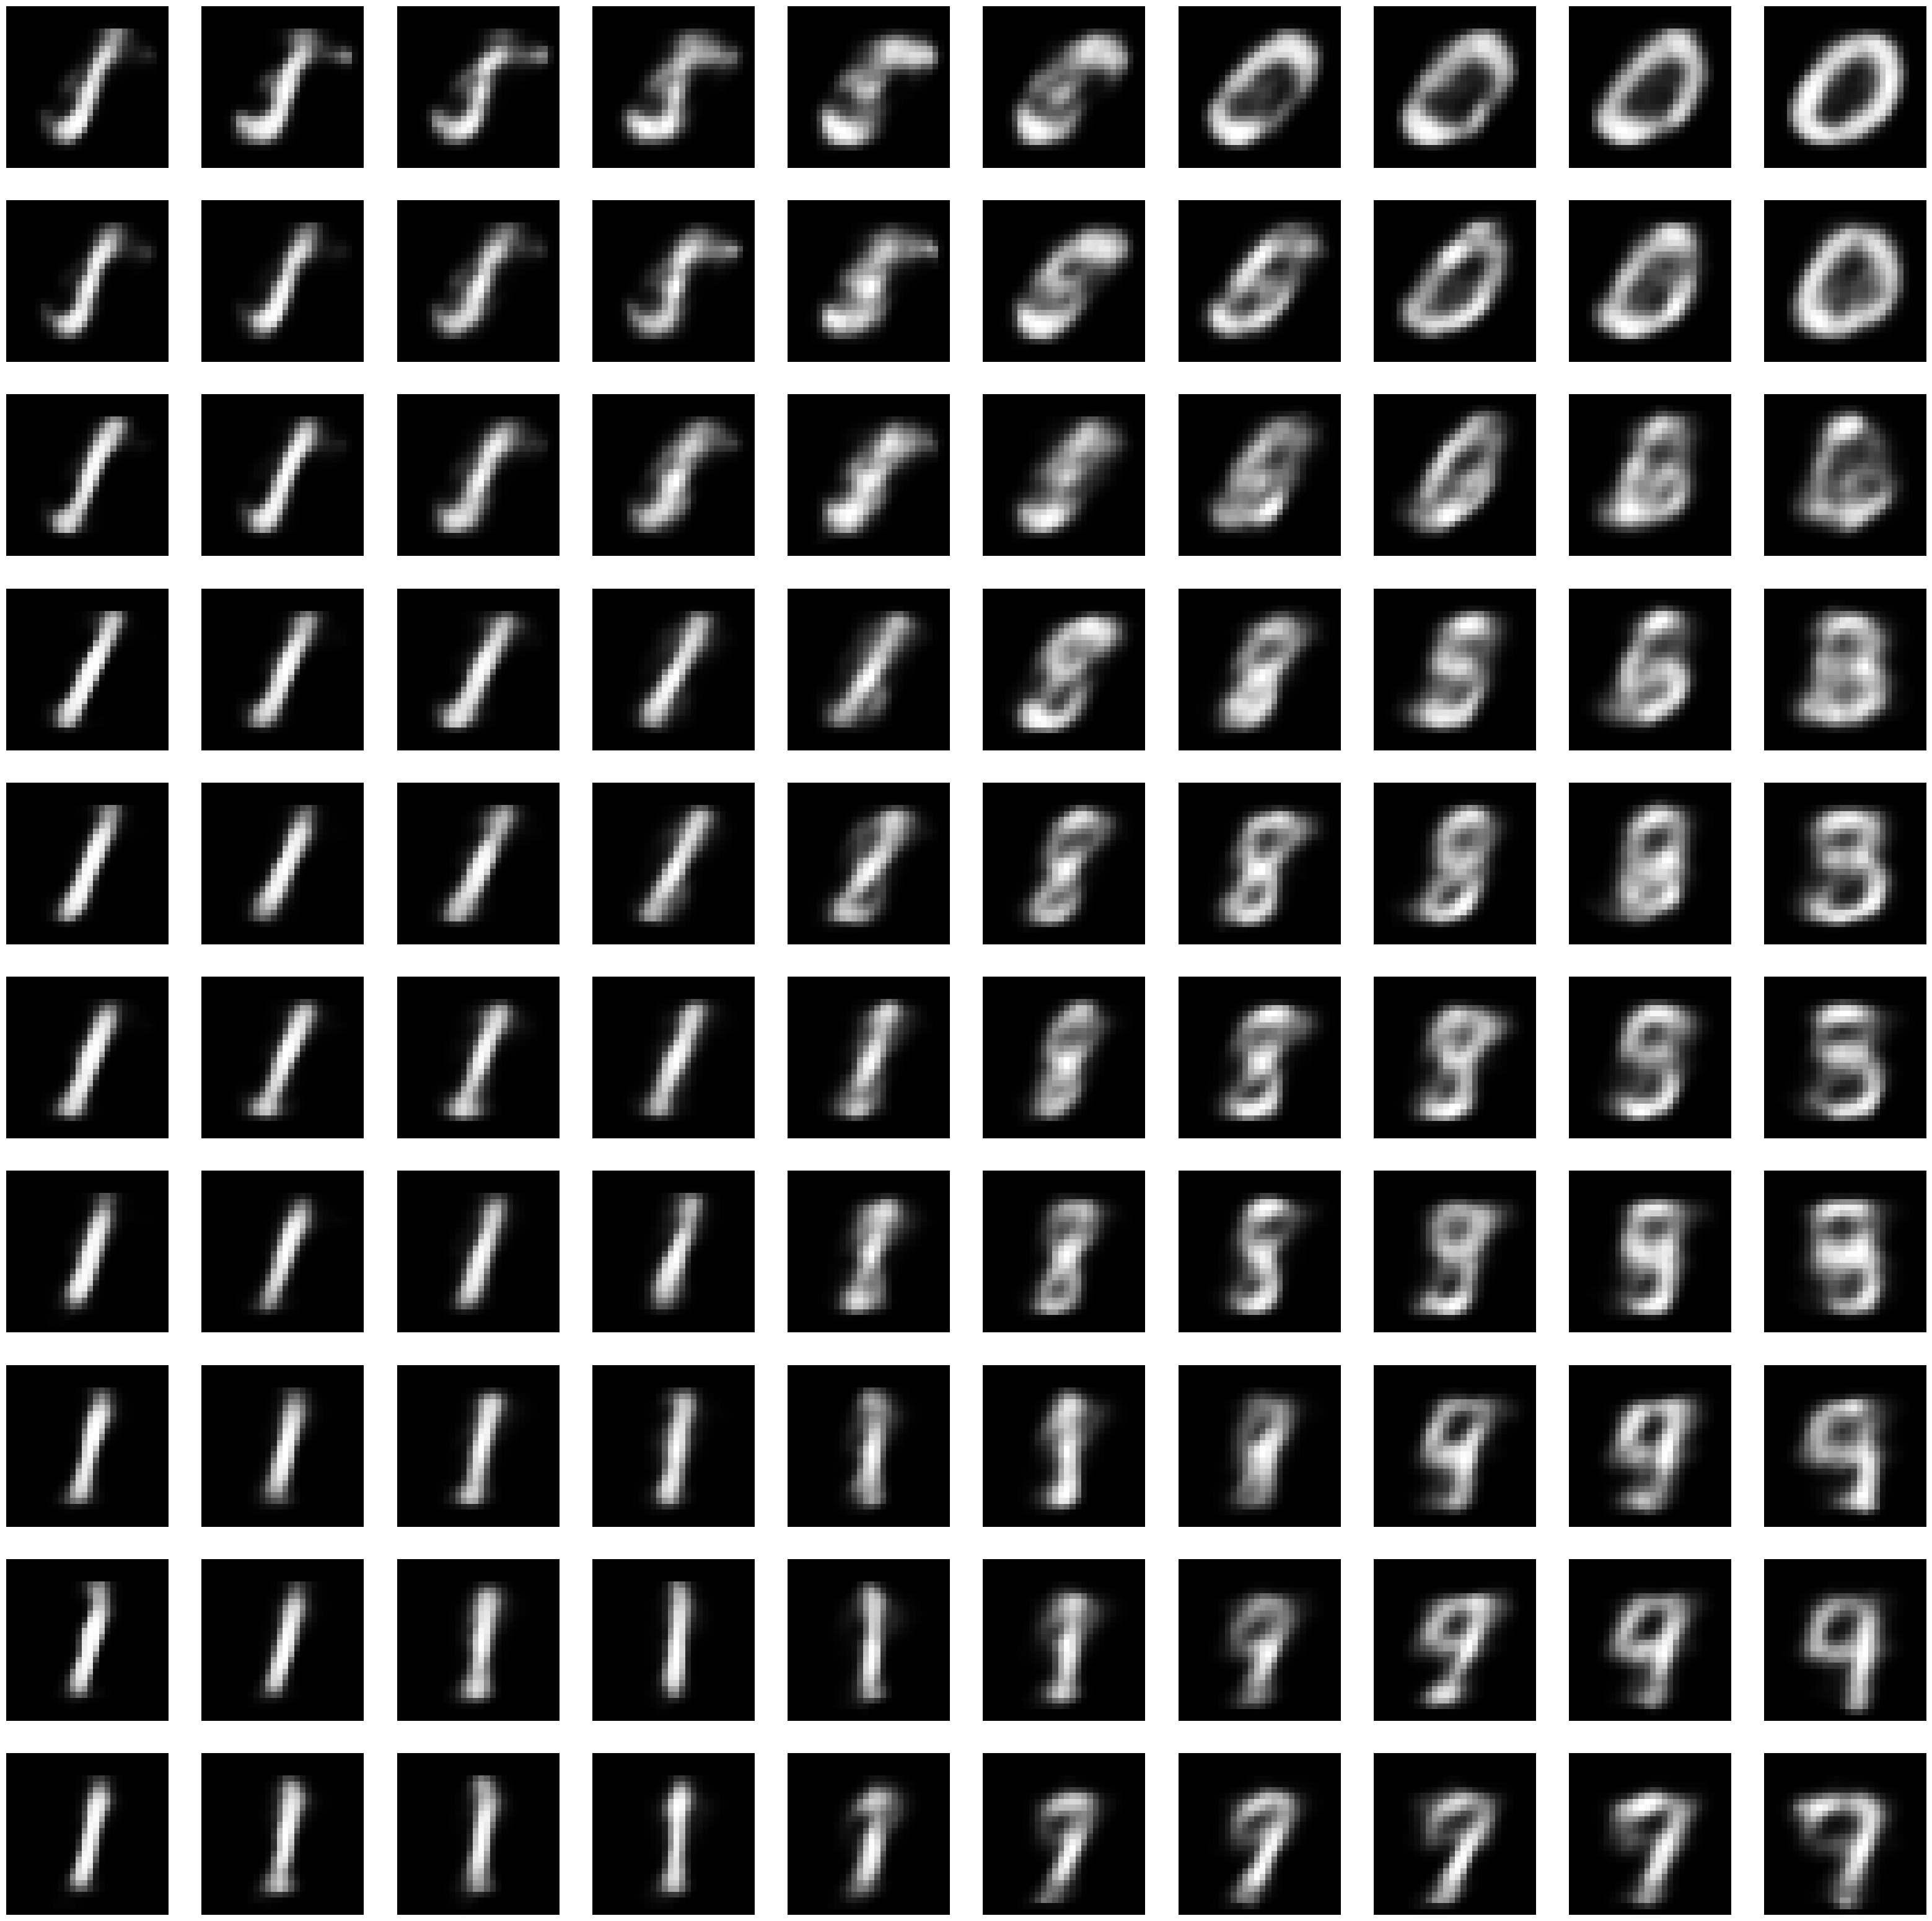

In [62]:
fig = plt.figure(figsize=(10*4, 10*4))
axes = fig.subplots(10, 10)

for i in range(10):
    for j in range(10):
        axes[i, j].imshow(sample_out[i, j], cmap='gray')
        axes[i, j].axis('off')

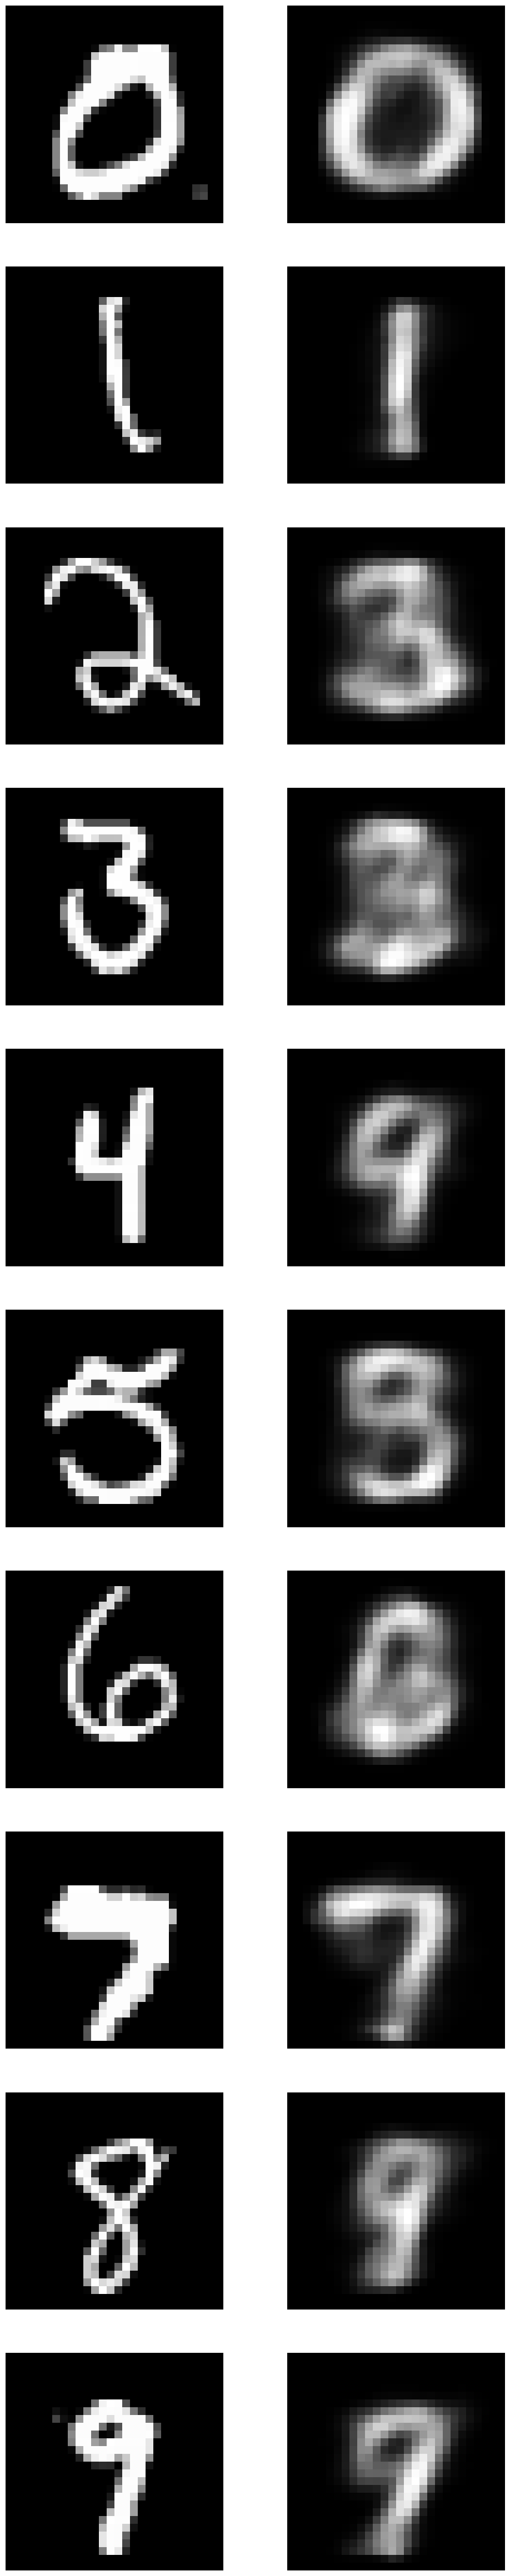

In [63]:
fig = plt.figure(figsize=(12, 6*10))
axes = fig.subplots(10, 2)
for i in range(10):
    number_index = np.random.permutation(np.argwhere(test_target == i))[0]
    number_sample = test_data[number_index]
    number_sample_out = model(torch.from_numpy(number_sample.reshape(1, -1))).detach().numpy().reshape(28, 28)
    
    axes[i][0].imshow(number_sample.reshape(28, 28), cmap='gray')
    axes[i][0].axis('off')
    axes[i][1].imshow(number_sample_out, cmap='gray')
    axes[i][1].axis('off')


# Proper Variational Autoencoder

In [64]:
EPOCHS=1000
BATCH_SIZE=128

In [65]:
class VAE(torch.nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(784, 400),
            torch.nn.Dropout(),
            torch.nn.Tanh(),
            torch.nn.Linear(400, 100),
            torch.nn.ELU(),
        )
        self.mean = torch.nn.Linear(100, 2)
        self.logvar = torch.nn.Linear(100, 2)
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 300),
            torch.nn.Dropout(0.5),
            torch.nn.Tanh(),
            torch.nn.Linear(300, 500),
            torch.nn.Dropout(0.5),
            torch.nn.Tanh(),
            torch.nn.Linear(500, 784),
            torch.nn.Sigmoid(),
        )

In [66]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def loss_fn(x, x_out, mean, logvar):
    BCE = torch.nn.functional.binary_cross_entropy(x_out, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return BCE + KLD

In [67]:
model.train()
losses = []
for epoch in progressbar(range(EPOCHS)):
    loss_agg = 0
    order = np.random.permutation(train_data.shape[0])
    train_x = train_data[order]
    train_y = train_target[order]
    for i in range(0, train_x.shape[0] // BATCH_SIZE):
        batch_x = torch.from_numpy(train_x[i*BATCH_SIZE:(i+1)*BATCH_SIZE])

        optimizer.zero_grad()
        encoder_output = model.encoder(batch_x)
        mean, logvar = model.mean(encoder_output), model.logvar(encoder_output)
        reparametrized = mean + torch.randn_like(mean) * torch.exp(logvar)
        decoded = model.decoder(reparametrized)
        loss = loss_fn(batch_x, decoded, mean, logvar)
        loss.backward()
        optimizer.step()
        loss_agg += loss.item()
        
    losses.append(loss_agg)

100% (1000 of 1000) |####################| Elapsed Time: 1:04:01 Time:  1:04:013414


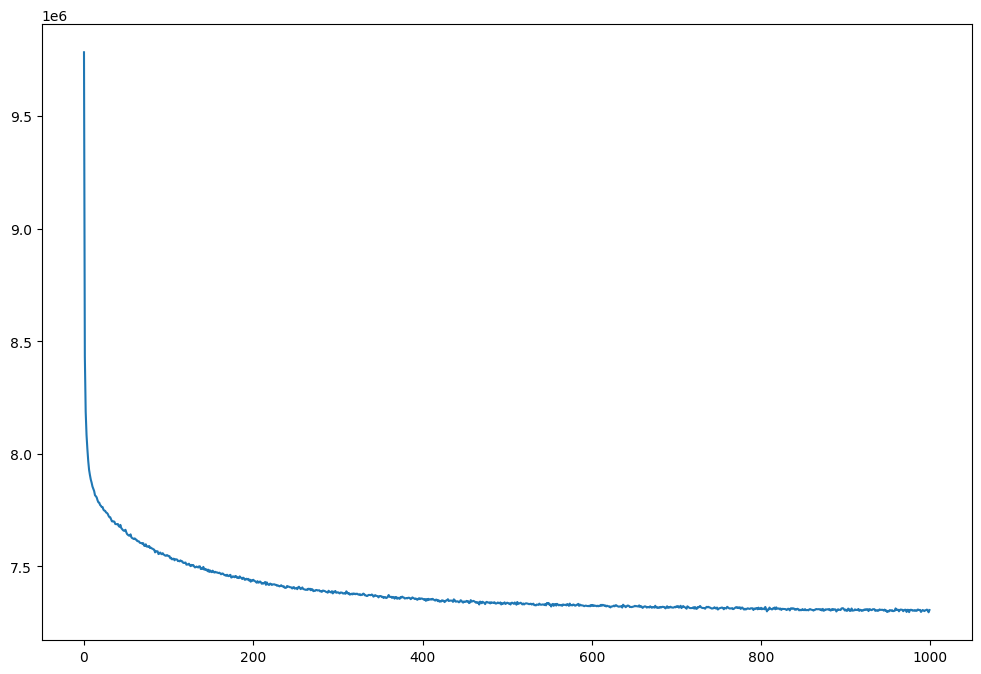

In [68]:
plt.figure(figsize=(12, 8))
plt.plot(losses)
plt.show()

In [69]:
torch.save(model.state_dict(), 'vae_autoencoder.pth')

In [70]:
model.load_state_dict(torch.load('vae_autoencoder.pth'))

<All keys matched successfully>

In [71]:
model.eval()
with torch.no_grad():
    sample_data = torch.tensor([[[i / 5 - 1, j / 5 - 1] for j in range(10)] for i in range(10)]).reshape((-1, 2))
    sample_out = model.decoder(sample_data).numpy().reshape(10, 10, 28, 28)

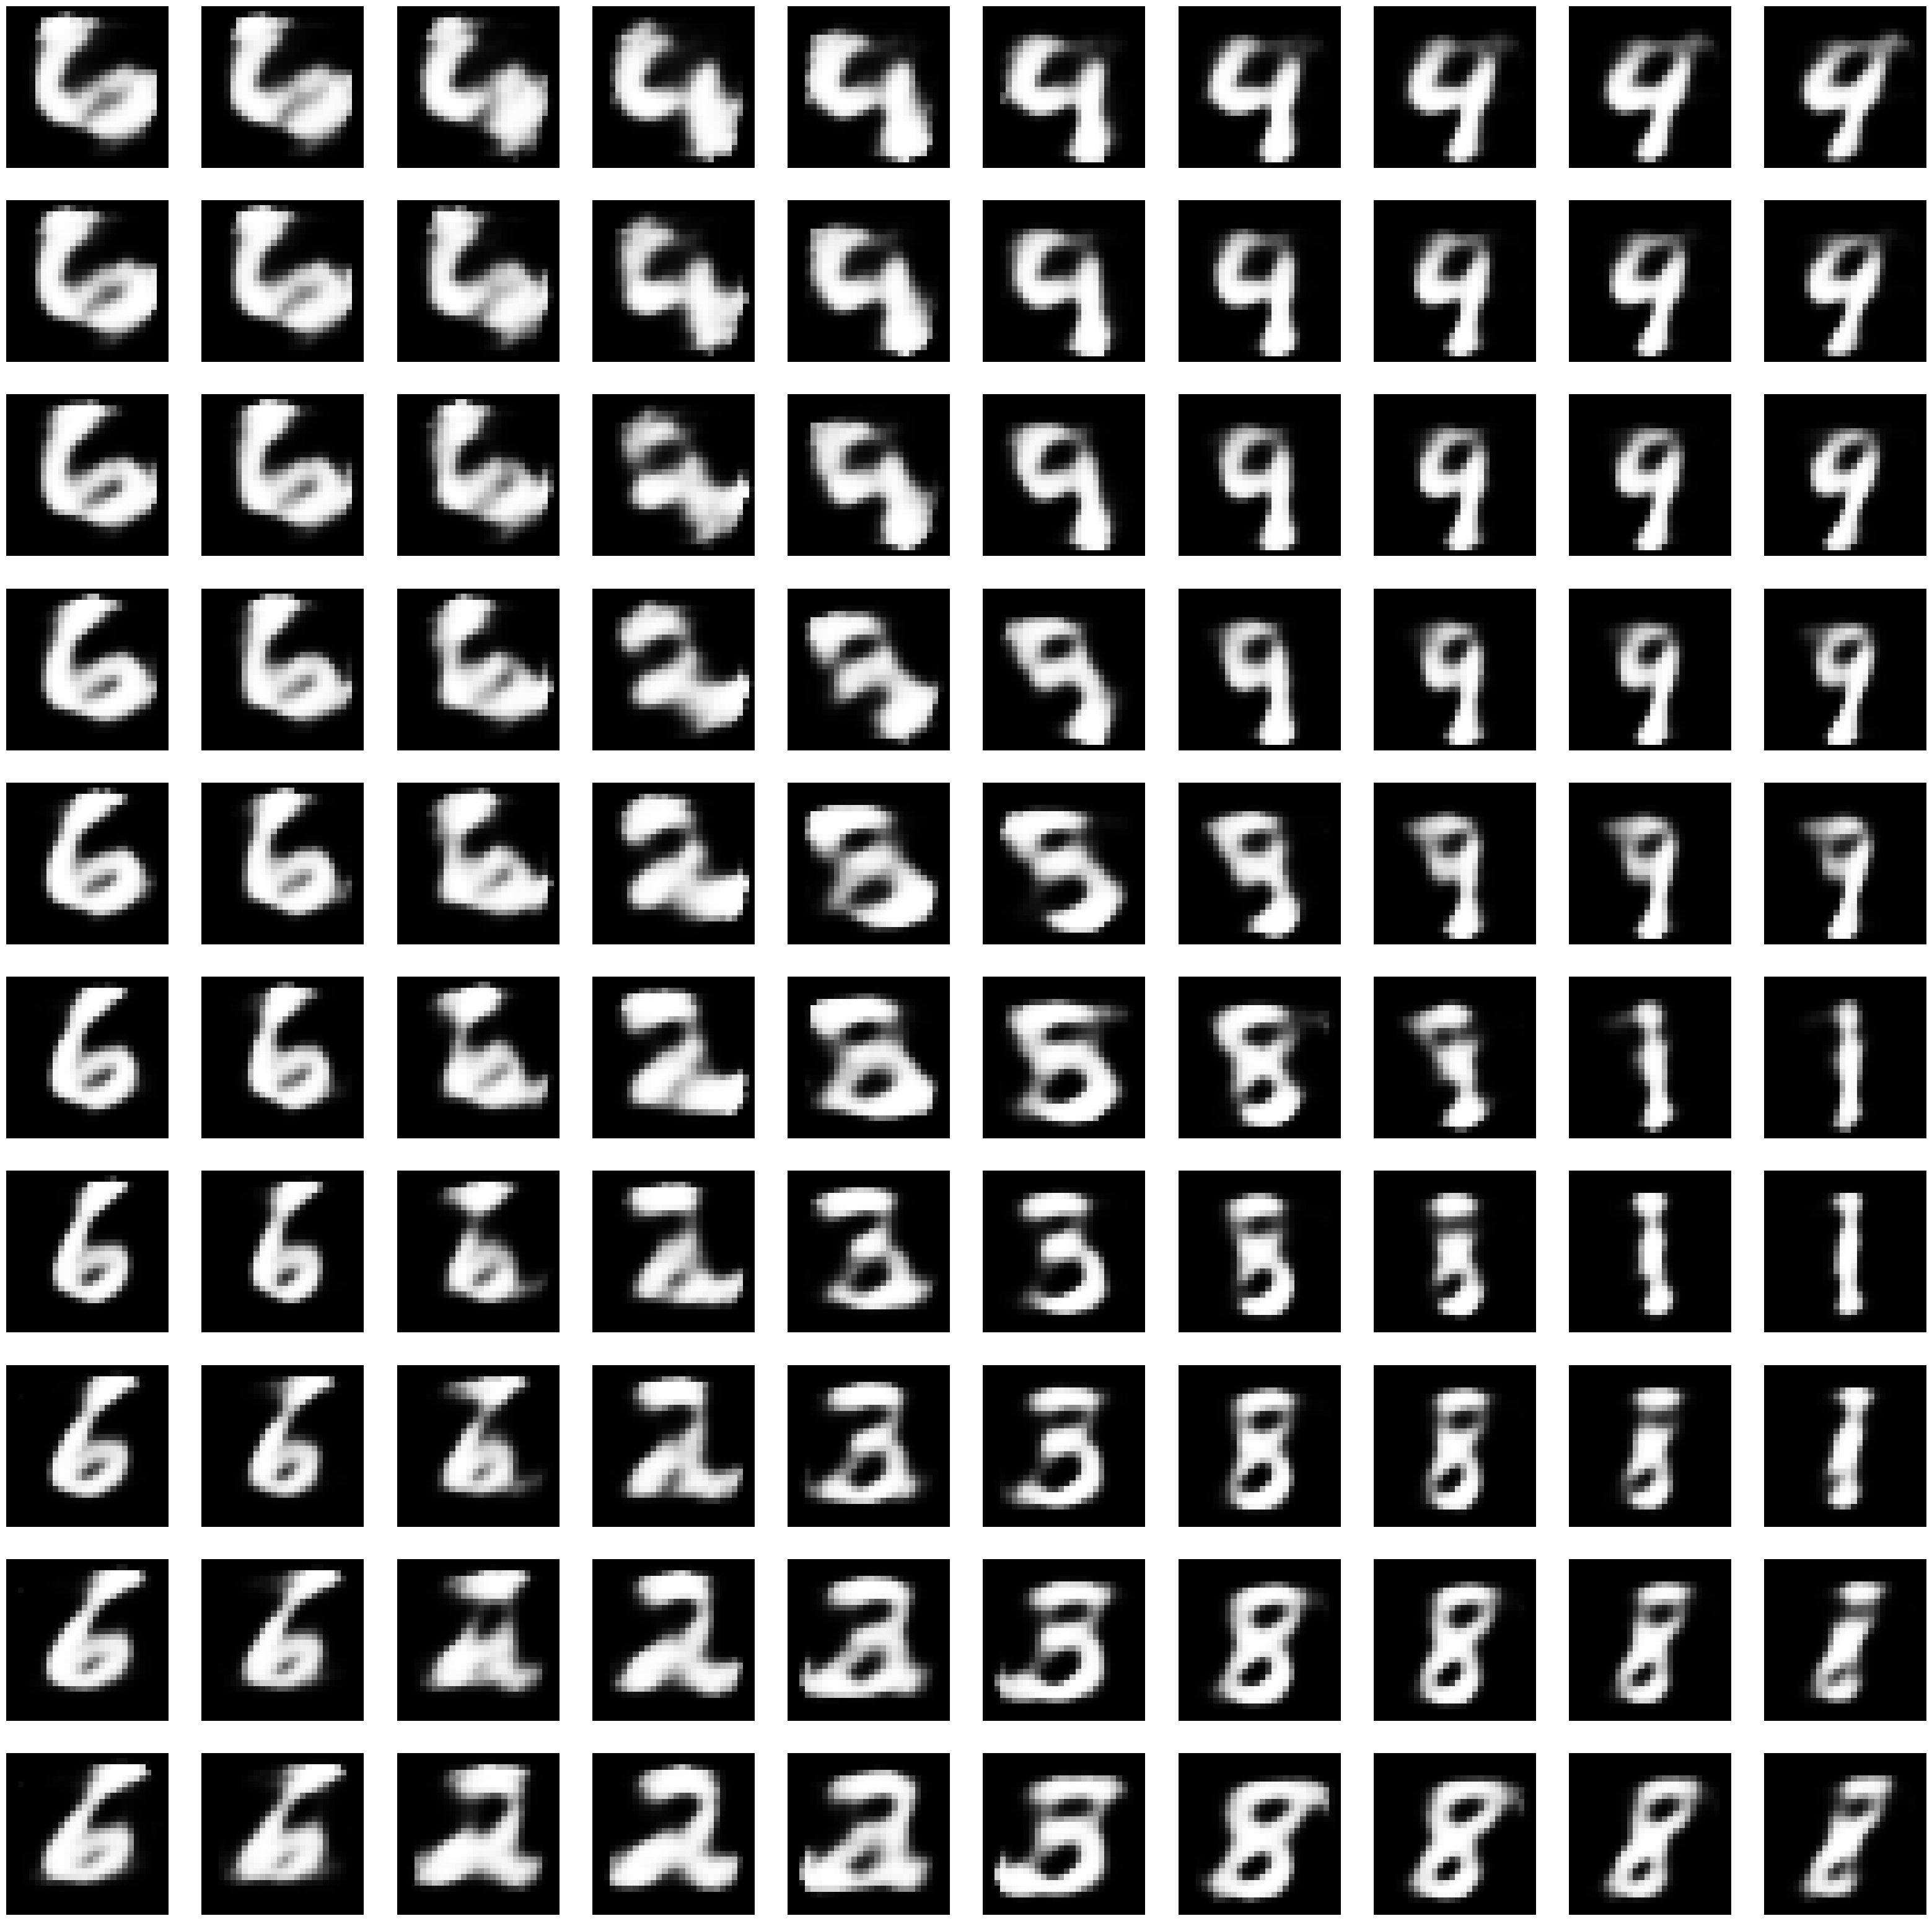

In [72]:
fig = plt.figure(figsize=(10*4, 10*4))
axes = fig.subplots(10, 10)

for i in range(10):
    for j in range(10):
        axes[i, j].imshow(sample_out[i, j], cmap='gray')
        axes[i, j].axis('off')

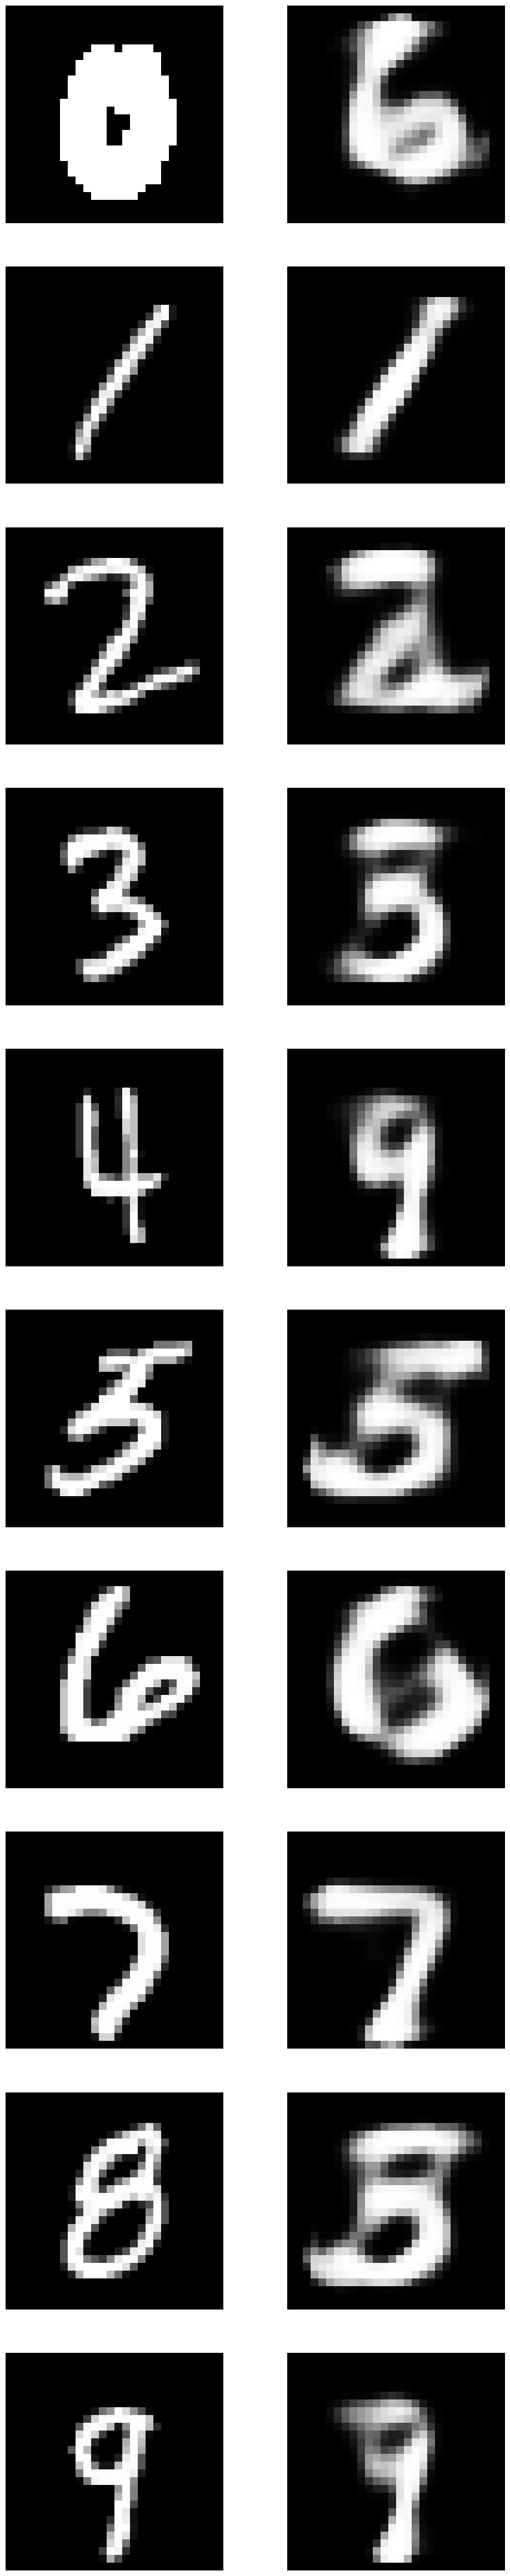

In [74]:
fig = plt.figure(figsize=(12, 6*10))
axes = fig.subplots(10, 2)
for i in range(10):
    number_index = np.random.permutation(np.argwhere(test_target == i))[0]
    number_sample = test_data[number_index]
    encoded = model.encoder(torch.from_numpy(number_sample.reshape(1, -1)))
    means = model.mean(encoded)
    number_sample_out = model.decoder(means).detach().numpy().reshape(28, 28)
    
    axes[i][0].imshow(number_sample.reshape(28, 28), cmap='gray')
    axes[i][0].axis('off')
    axes[i][1].imshow(number_sample_out, cmap='gray')
    axes[i][1].axis('off')
